In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMG_SIZE=256
BATCH_SIZE=32

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "plant",
    shuffle=True, ##it will shuffle randomly
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch,label_batch in dataset.take(2):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 2 1 0 0 0 1 0 0 1 1 1 0 0 2 0 0 1 1 0 1 0 1 0 0 0 2 0 0]
(32, 256, 256, 3)
[1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 2 1 0 1 0 0 0 0 0 1 2 1 1 0]


2025-02-15 15:03:30.352141: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[125. 114. 120.]
  [130. 119. 125.]
  [139. 128. 134.]
  ...
  [171. 164. 171.]
  [173. 166. 173.]
  [178. 171. 178.]]

 [[126. 115. 121.]
  [127. 116. 122.]
  [129. 118. 124.]
  ...
  [170. 163. 170.]
  [172. 165. 172.]
  [178. 171. 178.]]

 [[122. 111. 117.]
  [122. 111. 117.]
  [121. 110. 116.]
  ...
  [172. 165. 172.]
  [171. 164. 171.]
  [174. 167. 174.]]

 ...

 [[119. 107. 117.]
  [123. 111. 121.]
  [127. 115. 125.]
  ...
  [158. 152. 166.]
  [153. 147. 161.]
  [149. 143. 157.]]

 [[119. 107. 117.]
  [125. 113. 123.]
  [124. 112. 122.]
  ...
  [161. 154. 170.]
  [160. 153. 169.]
  [159. 152. 168.]]

 [[128. 116. 126.]
  [134. 122. 132.]
  [129. 117. 127.]
  ...
  [154. 147. 163.]
  [155. 148. 164.]
  [155. 148. 164.]]], shape=(256, 256, 3), dtype=float32)


2025-02-15 15:04:31.514190: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


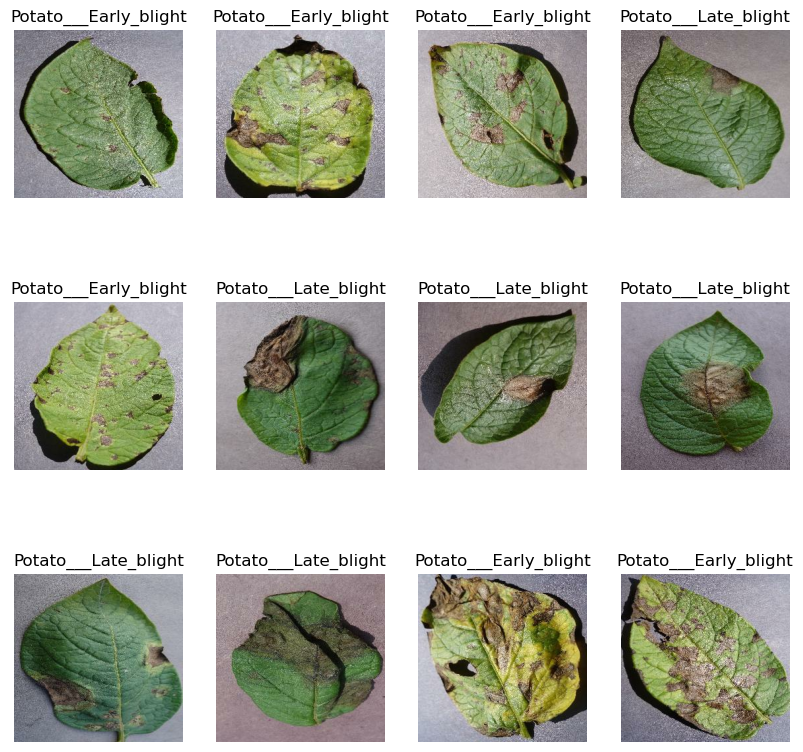

In [12]:
plt.figure(figsize=(10,10));
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [67]:
## 80%-tarin,10%-test,10%-validation
CHANNELS=3
EPOCHS=15

In [15]:
dataset.take(10) ## Take 10 samples

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [17]:
train_ds=dataset.take(54)

In [18]:
test_ds=dataset.skip(54)

In [19]:
val_size=0.1

In [20]:
val_ds=test_ds.take(6)

In [21]:
test_ds=test_ds.skip(6)

In [22]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*(ds_size))
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [23]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [24]:
len(train_ds)

54

In [27]:
## When Gpu is training the cpu will load the images that is gonna do by prefetch and improves the performance
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1.0/255)
])

In [32]:
## It will do all rotations of the image and add in the data set
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

## Building Model

In [33]:
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(), ## It will flatten at the end
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [68]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 605ms/step - accuracy: 0.9914 - loss: 0.0230 - val_accuracy: 0.9740 - val_loss: 0.0560
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 664ms/step - accuracy: 0.9950 - loss: 0.0121 - val_accuracy: 0.9896 - val_loss: 0.0257
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 698ms/step - accuracy: 0.9828 - loss: 0.0438 - val_accuracy: 0.9792 - val_loss: 0.0496
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 697ms/step - accuracy: 0.9892 - loss: 0.0455 - val_accuracy: 0.9375 - val_loss: 0.2398
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 612ms/step - accuracy: 0.9857 - loss: 0.0300 - val_accuracy: 0.9844 - val_loss: 0.0509
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - accuracy: 0.9939 - loss: 0.0245 - val_accuracy: 0.9635 - val_loss: 0.1354
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - accuracy: 0.9955 - loss: 0.0134 - val_accuracy: 0.9792 - val_loss: 0.0884
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 655ms/step - accuracy: 0.9973 - loss: 0.0096 - val_accu

In [70]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9893 - loss: 0.0180


In [71]:
scores

[0.011512935161590576, 0.9921875]

In [72]:
history

In [73]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [74]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [75]:
history.history['accuracy']

[0.9913194179534912,
 0.9930555820465088,
 0.9849537014961243,
 0.9878472089767456,
 0.9855324029922485,
 0.9947916865348816,
 0.9953703880310059,
 0.9942129850387573,
 0.9924768805503845,
 0.9936342835426331,
 0.9924768805503845,
 0.9936342835426331,
 0.9901620149612427,
 0.9953703880310059,
 0.9930555820465088]

In [76]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

Text(0.5, 1.0, 'Training vs Validation Accuracy')

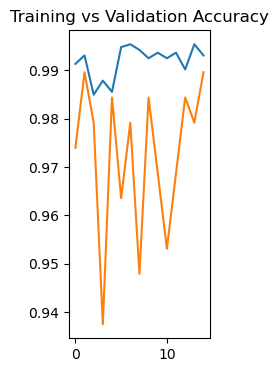

In [79]:
plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training_acc")
plt.plot(range(EPOCHS),val_acc,label="Val_acc")
plt.title("Training vs Validation Accuracy")

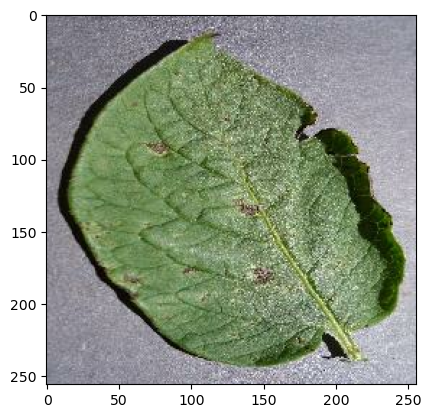

In [80]:
for images_batch,labels_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))

In [52]:
import numpy as np

Predict
label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
[1.0000000e+00 1.6619296e-17 0.0000000e+00]
0
Predict: Potato___Early_blight


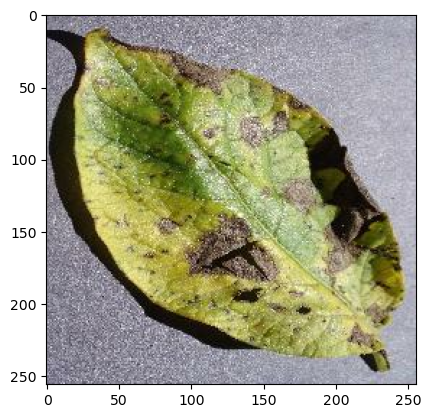

In [127]:
for images_batch,labels_batch in test_ds.take(1):
    img=images_batch[0].numpy().astype('uint8')
    label=label_batch[0].numpy()

    print("Predict")
    plt.imshow(img)
    print("label:",class_names[label])

    batch_prediction=model.predict(images_batch)
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    print("Predict:",class_names[np.argmax(batch_prediction[0])])

In [93]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


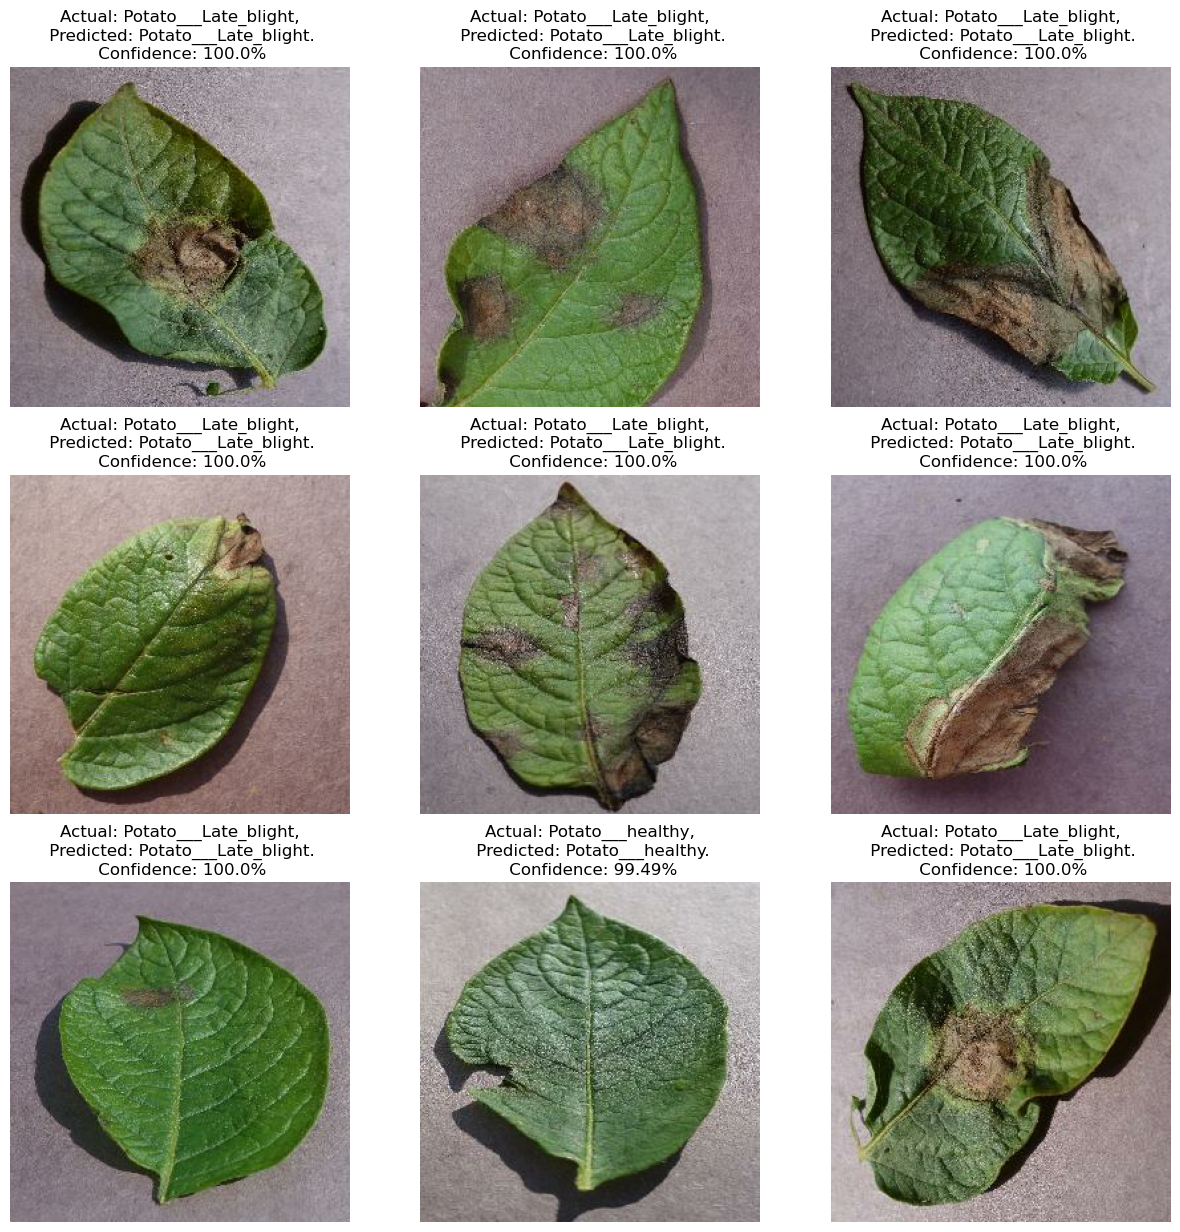

In [95]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Save the model

In [99]:
from tensorflow import keras

In [101]:
import os

In [105]:
os.listdir("../models")

['.ipynb_checkpoints', '1.keras']

In [109]:
model_version = 2  # Ensure this is a string
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets


INFO:tensorflow:Assets written to: ../models/2/assets


Saved artifact at '../models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13573909456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13573910416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13573911376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13573912720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13573912912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13573913680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13573913488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13573914064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13573913104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13573911952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13574766864: TensorSpec(shape=(), dtype=tf.resource, name=N

In [122]:
model.save('my_model.keras')

In [125]:
try:
    models = tf.keras.models.load_model("/Users/saivarun/Documents/Projects/Models/my_model.keras")
    print("✅ Model loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")

✅ Model loaded successfully


In [126]:
models.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,675 (3.18 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,784 (2.12 MB)